In [2]:
#MCMC FIT TO HST DATA INCLUDING BOTH ERI II AND CLUSTER, BINNED BY 30 PIXELS, AND MASKED 
#APPROPRIATELY
#PLUMMER PROFILE FOR ERI II, SERSIC PROFILE FOR CLUSTER
#UPDATED TO FIT ALL MODEL PARAMETERS INSTEAD OF JUST RICHNESS AND CENTER POSITION
import numpy as np
import pylab as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
# from matplotlib.mlab import rec2csv

import emcee
import corner

from astropy.io import ascii

In [3]:
#READ IN PHOTOMETRY FROM AN ASCII FILE
cat = ascii.read("eri2.cat")  

x=cat[cat.colnames[0]]
y=cat[cat.colnames[1]]
m606=cat[cat.colnames[2]]
dm606=cat[cat.colnames[3]]
m814=cat[cat.colnames[4]]
dm814=cat[cat.colnames[5]]
flag=cat[cat.colnames[6]]


#CLEAN CATALOG
#CUT ON ALL FLAGS *EXCEPT* BRIGHT NEIGHBORS (WHICH WOULD ELIMINATE ALL OF THE CLUSTER STARS)
#ALSO ELIMINATE STARS FAINTER THAN 90% COMPLETENESS LIMIT AND TOO RED TO BE DWARF GALAXY MEMBERS
good = ((flag & 1) == 0) & ((flag & 2) == 0) & ((flag & 4) == 0) & ((flag & 8) == 0) & ((flag & 1024) == 0) & (m814 < 29.15) & (m606 < 28.70) & (m606-m814 < 0)
good_indices = [i for i, test in enumerate(good) if test]
#OR good_indices = np.where(good)[0]
xgood = x[good_indices]
ygood = y[good_indices]

In [4]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA

#IMAGE BOUNDARY
IMAGE = Path([ [406,2390],
              [2190,7814],
              [7662,5536],
              [5704,5],
              [406,2390]])

#ACS CHIP GAP
GAP = Path([ [4842, 6714],
             [4905, 6686],
             [3037, 1208],
             [2977, 1233],
             [4842, 6714]])

IMG_BIT = 0b01
GAP_BIT = 0b10

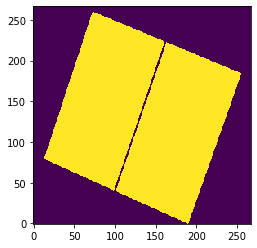

In [5]:
#DEFINE A GRID OF 30X30 PIXEL BINS COVERING THE IMAGE
NBINS = 268
XMIN,XMAX = 0,8010
YMIN,YMAX = 0,8010
XEDGE = np.linspace(XMIN,XMAX,NBINS)
YEDGE = np.linspace(XMIN,XMAX,NBINS)

#BIN CENTERS
XCENT = (XEDGE[1:] + XEDGE[:-1])/2.
YCENT = (YEDGE[1:] + YEDGE[:-1])/2.
#BIN SIZE
XDEL = XEDGE[1]-XEDGE[0]
YDEL = YEDGE[1]-YEDGE[0]

# Pixel area in deg^2; pixel scale is 0.035"/pixel, 
PIXAREA  =((0.035/3600.)*XDEL)*( (0.035/3600.)*YDEL)

# Pre-calculate these instead of doing it in each evaluation of the model...
XX,YY= np.meshgrid(XCENT,YCENT,indexing='ij')


#USE THE MASKED REGIONS FROM ABOVE TO CREATE AN IMAGE MASK WITH THE APPROPRIATE BINNING
#REQUIRES FLATTENING THE ARRAYS
MASK = np.zeros((NBINS-1,NBINS-1))
image_mask = IMAGE.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
gap_mask = GAP.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_image = np.where(image_mask==1) # Array indices
masked_indices_gap = np.where(gap_mask==1) # Array indices
MASK[masked_indices_image] = 1
MASK[masked_indices_gap] = 0
IDX = np.where(MASK==1)

#DISPLAY THE MASK TO CHECK THAT IT'S CORRECT
plt.imshow(MASK.T,origin='lower')

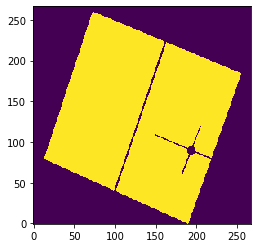

In [6]:
#ADD HIGHLY SATURATED STAR IN THE WEST TO MASK
satstar_xcen = 5820.0
satstar_ycen = 2710.0
near_satstar = np.where( np.sqrt((XX - satstar_xcen)**2 + (YY - satstar_ycen)**2) < 160)
MASK[near_satstar] = 0

DIFF_SPIKES_EW = Path([ [4472, 3265],
                        [4488, 3300],
                        [6589, 2412],
                        [6572, 2363],
                        [4472, 3265]])
spikes_mask_ew = DIFF_SPIKES_EW.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_spikes_ew = np.where(spikes_mask_ew==1) # Array indices
MASK[masked_indices_spikes_ew] = 0
DIFF_SPIKES_NS = Path([ [6144, 3613],
                        [6173, 3601],
                        [5492, 1803],
                        [5445, 1817],
                        [6144, 3613]])
spikes_mask_ns = DIFF_SPIKES_NS.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_spikes_ns = np.where(spikes_mask_ns==1) # Array indices
MASK[masked_indices_spikes_ns] = 0
plt.imshow(MASK.T,origin='lower')

In [7]:
#DEFINE INITIAL MODEL PARAMETERS FOR ERI II
ERI_NSTAR = 28000                # Richness
#ERI_LON = 56.0888               # RA (deg)
#ERI_LAT = -43.5304              # Dec (deg)
ERI_X0 = 4000                    # X Center (pix)
ERI_Y0 = 3700                    # Y Center (pix)
ERI_EXT = 2.31/60.               # Extension (deg)
ERI_EXT_PIX = 4000               # Extension (pix)
ERI_ELL = 0.41                   # Ellipticity
ERI_PA = 72.6                    # Position angle (deg)

In [8]:
#DEFINE INITIAL MODEL PARAMETERS FOR SECOND COMPONENT (CENTRAL CLUSTER IN THE CASE OF ERI II)
CLUSTER_NSTAR = 500                      # Richness
CLUSTER_X0 = 3700                        # X Center (pix)
CLUSTER_Y0 = 3600                        # Y Center (pix)
CLUSTER_EXT = 7.67/3600.                 # Extension (deg)
CLUSTER_EXT_PIX = 300                    # Extension (pix)
CLUSTER_ELL = 0.30                       # Ellipticity
CLUSTER_PA = 75.                         # Position angle (deg)
CLUSTER_N = 0.41                         # Sersic index

In [9]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [10]:
def data(x,y):
    """ Calculate the binned data counts. This only needs to be done
    once (not at each model evaluation), but this seemed easier to
    understand if it paralleled the model counts calculation.

    Parameters
    ----------
    x : the x coordinate of the data
    y : the y coordinate of the data

    Returns
    -------
    data_counts : the data counts in each bin
    """
    data_counts,_,_ = np.histogram2d(x,y,bins=[XEDGE,YEDGE])
    return data_counts

In [11]:
def new_kernel(x,y,lon=ERI_X0,lat=ERI_Y0,ext=ERI_EXT_PIX,ell=ERI_ELL,pa=ERI_PA):
    """ Evaluate the elliptical exponential kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    # Exponential radius (re = rh/1.68)
    r_e = ext/1.68 
    #Normalization (integrates to unity over all space) [stars/pix^2)
    norm = 1./(2*np.pi*r_e**2 * (1-ell) )

    # Exponential PDF
    pdf = norm * np.exp(-radius/r_e)

    return pdf

In [12]:
def new_kernel_plummer(x,y,lon=ERI_X0,lat=ERI_Y0,ext=ERI_EXT_PIX,ell=ERI_ELL,pa=ERI_PA):
    """ Evaluate the elliptical Plummer kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [13]:
def model(theta_eri2):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """
    #FIT ALL MODEL PARAMETERS
    richness = theta_eri2[0]
    kwargs = dict(lon=theta_eri2[1],lat=theta_eri2[2],ext=theta_eri2[3],ell=theta_eri2[4],pa=theta_eri2[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    # Default values for the other parameters
    #kwargs.update(ext=ERI_EXT_PIX,ell=ERI_ELL)

    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE GALAXY
    # The new kernel in pixel coordinates
    pdf = new_kernel_plummer(XX,YY,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = XDEL*YDEL
    model_counts = richness * pdf * pixarea
    return model_counts

In [14]:
def new_kernel_cluster(x,y,lon=CLUSTER_X0,lat=CLUSTER_Y0,ext=CLUSTER_EXT_PIX,ell=CLUSTER_ELL,pa=CLUSTER_PA):
    """ Evaluate the elliptical exponential kernel for the second component [cluster] at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    # Exponential radius (re = rh/1.68)
    r_e = ext/1.68 
    #Normalization (integrates to unity over all space) [stars/pix^2)
    norm = 1./(2*np.pi*r_e**2 * (1-ell) )

    # Exponential PDF
    pdf = norm * np.exp(-radius/r_e)

    return pdf

In [15]:
def new_kernel_cluster_plummer(x,y,lon=CLUSTER_X0,lat=CLUSTER_Y0,ext=CLUSTER_EXT_PIX,ell=CLUSTER_ELL,pa=CLUSTER_PA):
    """ Evaluate the elliptical Plummer kernel for the second component [cluster] at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]
#    bg:  surface density of non-cluster stars [pix^-2]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [16]:
def new_kernel_cluster_sersic(x,y,lon=CLUSTER_X0,lat=CLUSTER_Y0,nserc=CLUSTER_N,ext=CLUSTER_EXT_PIX,ell=CLUSTER_ELL,pa=CLUSTER_PA):
    """ Evaluate the elliptical Sersic kernel for the second component [cluster] at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]
    nserc: Sersic index
#    bg:  surface density of non-cluster stars [pix^-2]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #Normalization (integrates to unity over all space) [stars/pix^2)
    #I_e = 5*(b_0.3)^0.6*e^(-b_0.3)/(3*pi*(1-ell)*r_h^2*Gamma(0.6))
    #Calculate b_n from Gamma(2n) = 2*igamma(2n,b_n)

    #SERSIC SCALE RADIUS = HALF-LIGHT RADIUS 
    r_h = ext
    #ONLY VALID FOR N=0.41
    norm = 0.753/(np.pi * r_h**2 * (1-ell) )
    
    #Sersic PDF
    pdf = norm * np.exp(-0.6531*(radius/r_h)**(1/nserc))

    return pdf

In [17]:
def model_cluster(theta_cluster):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """

    #FIT ALL MODEL PARAMETERS    
    richness = theta_cluster[0]
    kwargs = dict(lon=theta_cluster[1],lat=theta_cluster[2],ext=theta_cluster[3],ell=theta_cluster[4],pa=theta_cluster[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    # Default values for the other parameters
    #kwargs.update(ext=CLUSTER_EXT_PIX,ell=CLUSTER_ELL,pa=CLUSTER_PA)

    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE SECOND COMPONENT [CLUSTER]
    # The new kernel in pixel coordinates
    pdf = new_kernel_cluster_sersic(XX,YY,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = XDEL*YDEL
    model_counts_cluster = richness * pdf * pixarea
    return model_counts_cluster

In [18]:
def lnlike(theta, x, y):
    """ Likelihood function
    Parameters
    ----------
    theta : model parameter array (richness,lon,lat,ext,ell,pa)x2
    x: x-coordinate of data
    y: y-coordinate of data
    
    Returns
    -------
    lnlike: log-likelihood
    """

    #BREAK THETA UP INTO ERI II AND CLUSTER COMPONENTS
    #IF ONLY ONE COMPONENT IS BEING FIT, THEN THESE LINES ARE NOT NEEDED
    theta_eri2 = theta[:6]
    theta_cluster = theta[6:]
    
    # Calculate the data counts and model predicted counts in each pixel bin
    data_counts = data(x,y)
    model_counts_eri2 = model(theta_eri2)
    model_counts_cluster = model_cluster(theta_cluster)
    #TO FIT A SINGLE COMPONENT, USE, E.G., MODEL_COUNTS = MODEL_COUNTS_ERI2
    model_counts = model_counts_eri2 + model_counts_cluster
    
    # Apply the mask to the data and model. This selects only pixels
    # in the image for calculating the likelihood.
    data_counts_masked = data_counts[IDX]
    model_counts_masked = model_counts[IDX]
    
    # Evaluate Equation C2 from Drlica-Wagner et al. 2020 (1912.03302; ignore k! term)
    lnlike = np.sum(-model_counts_masked + data_counts_masked * np.log(model_counts_masked))
    return lnlike

In [19]:
def lnprior(theta):
    """ The log-prior. Add whatever you want here... 
    
    Parameters
    ----------
    theta : model parameters

    Returns
    -------
    lnprior : log-prior
    """
    #PRIORS FOR EACH FITTED PARAMETER
    #TO REMOVE ANY PARAMETER FROM THE FIT, REMOVE IT FROM THE LINE BELOW AND ELIMINATE THE CONSTRAINT FOR IT
    rich1,lon1,lat1,ext1,ell1,pa1,rich2,lon2,lat2,ext2,ell2,pa2 = theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],theta[7],theta[8],theta[9],theta[10],theta[11]
    if not (5000 < rich1 < 40000):  return np.inf
    if not (3000 < lon1 < 5000): return np.inf
    if not (3000 < lat1 < 5000): return np.inf
    if not (2000 < ext1 < 8000): return np.inf
    if not (0.1 < ell1 < 0.9): return np.inf
    if not (50 < pa1 < 90): return np.inf

    if not (200 < rich2 < 1200):  return np.inf
    if not (3550 < lon2 < 3850): return np.inf
    if not (3500 < lat2 < 3800): return np.inf
    if not (150 < ext2 < 800): return np.inf
    if not (0.0 < ell2 < 0.7): return np.inf
    if not (30 < pa2 < 120): return np.inf
    return 0

In [20]:
def lnprob(theta, x, y):
    """ The log-probability = lnlike + lnprob 

    Parameters
    ----------
    theta : the model parameter vector
    x     : x-coord of the data
    y     : y-coord of the data
    
    Returns
    -------
    lnprob : log-probability
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

Running mcmc...
Writing results_b267_s3000.csv ...


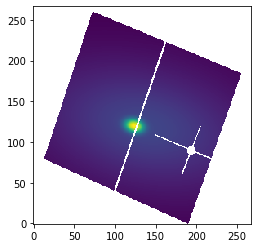

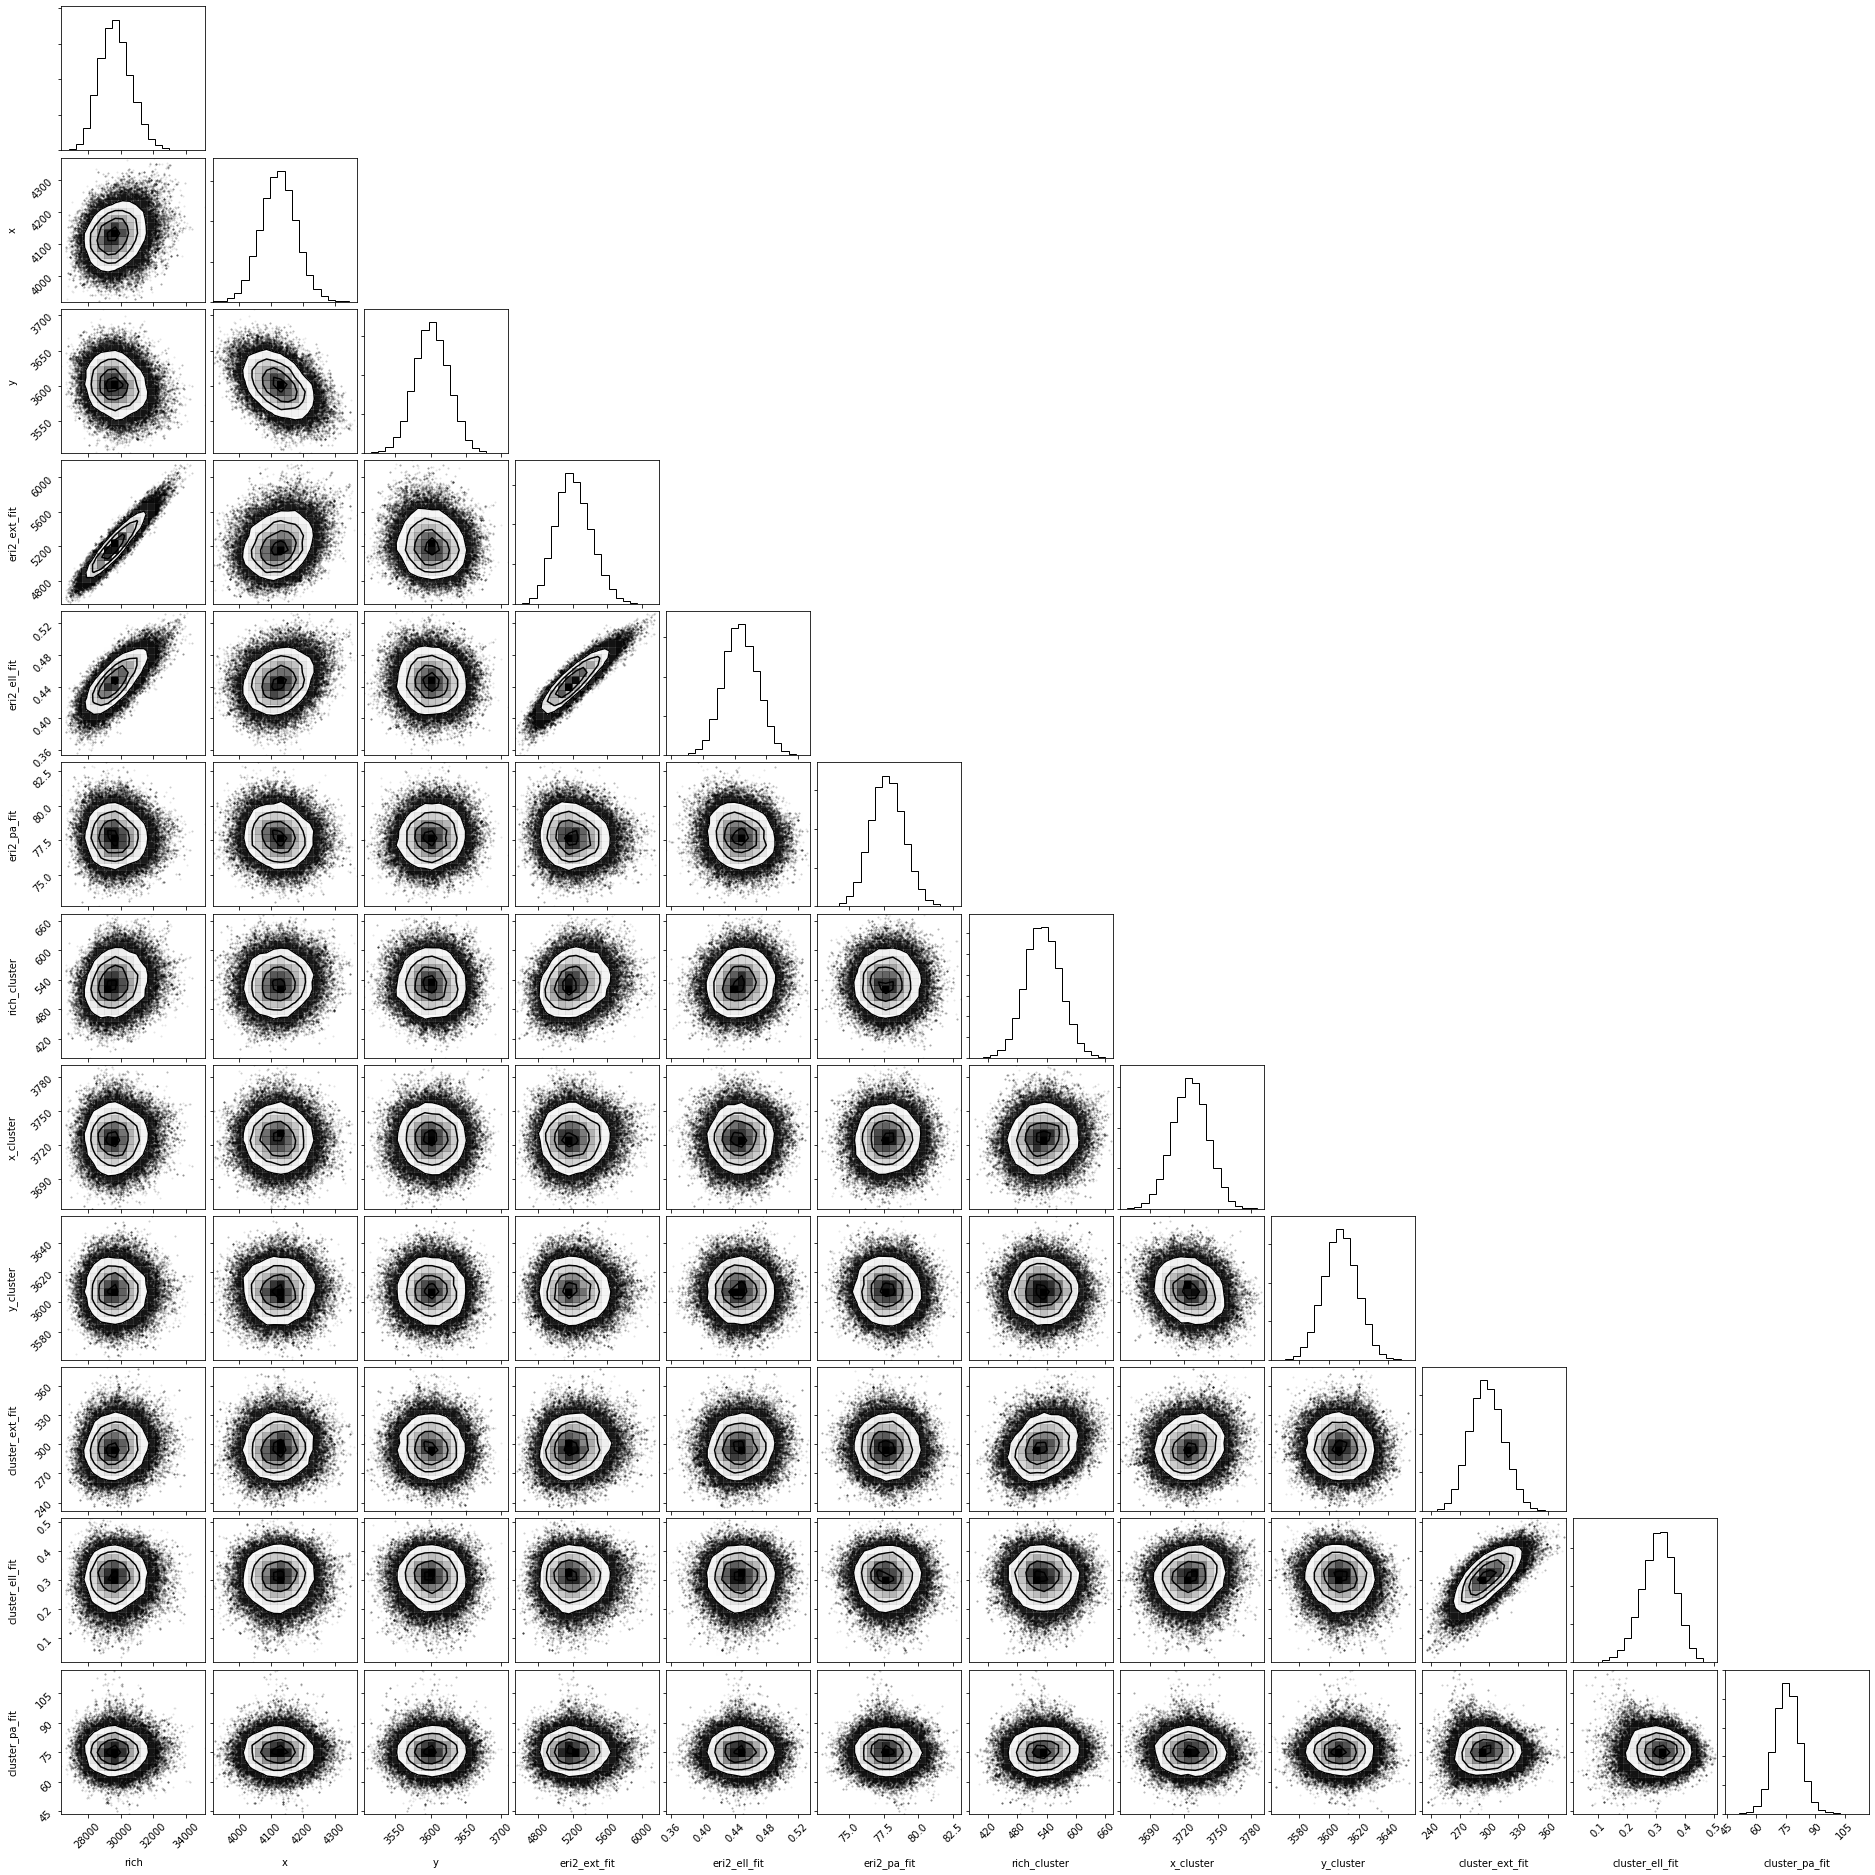

In [21]:
#FLAG FOR DISPLAYING PLOTS
do_plot=True
save_plot=False

#SET INITIAL GUESSES FOR PARAMETERS (ANY PARAMETERS NOT BEING FIT SHOULD BE REMOVED HERE)
THETA = [ERI_NSTAR,ERI_X0,ERI_Y0,ERI_EXT_PIX,ERI_ELL,ERI_PA,CLUSTER_NSTAR,CLUSTER_X0,CLUSTER_Y0,CLUSTER_EXT_PIX,CLUSTER_ELL,CLUSTER_PA]


#PLOT (MASKED, BINNED) OBSERVED SURFACE DENSITY
if do_plot:
    # Example of the masked counts and data
    # (transpose due to difference between imshow and histogram2d...)
    data_counts = data(xgood,ygood)
    data_counts_masked = np.copy(data_counts)
    data_counts_masked[np.where(MASK==0)] = np.nan
    plt.imshow(data_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('data_counts_masked.png')


#VARIABLE TO HOLD FIT RESULTS
results = []
     
# Initialize and run the mcmc
print("Running mcmc...")
ndim, nwalkers = len(THETA), 100
nthreads,nsamples = 16, 3000
nburn = 1000
pos = [THETA + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
     
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(xgood,ygood),
                                threads=nthreads)
sampler.run_mcmc(pos,nsamples)
     
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich,[rich_min,rich_max] = median_interval(samples[:,0])
x,[xmin,xmax] = median_interval(samples[:,1])
y,[ymin,ymax] = median_interval(samples[:,2])
eri2_ext_fit,[eri2_ext_min,eri2_ext_max] = median_interval(samples[:,3])
eri2_ell_fit,[eri2_ell_min,eri2_ell_max] = median_interval(samples[:,4])
eri2_pa_fit,[eri2_pa_min,eri2_pa_max] = median_interval(samples[:,5])

rich_cluster,[rich_cluster_min,rich_cluster_max] = median_interval(samples[:,6])
x_cluster,[x_cluster_min,x_cluster_max] = median_interval(samples[:,7])
y_cluster,[y_cluster_min,y_cluster_max] = median_interval(samples[:,8])
cluster_ext_fit,[cluster_ext_min,cluster_ext_max] = median_interval(samples[:,9])
cluster_ell_fit,[cluster_ell_min,cluster_ell_max] = median_interval(samples[:,10])
cluster_pa_fit,[cluster_pa_min,cluster_pa_max] = median_interval(samples[:,11])


#POPULATE RESULTS ARRAY
res = [rich,rich_min,rich_max,x,xmin,xmax,y,ymin,ymax,eri2_ext_fit,eri2_ext_min,eri2_ext_max,eri2_ell_fit,eri2_ell_min,eri2_ell_max,eri2_pa_fit,eri2_pa_min,eri2_pa_max,rich_cluster,rich_cluster_min,rich_cluster_max,x_cluster,x_cluster_min,x_cluster_max,y_cluster,y_cluster_min,y_cluster_max,cluster_ext_fit,cluster_ext_min,cluster_ext_max,cluster_ell_fit,cluster_ell_min,cluster_ell_max,cluster_pa_fit,cluster_pa_min,cluster_pa_max]
results.append(res)

if do_plot:
    theta_eri2 = [rich,x,y,eri2_ext_fit,eri2_ell_fit,eri2_pa_fit]
    theta_cluster = [rich_cluster,x_cluster,y_cluster,cluster_ext_fit,cluster_ell_fit,cluster_pa_fit]
    model_counts_eri2 = model(theta_eri2)
    model_counts_cluster = model_cluster(theta_cluster)
    model_counts = model_counts_eri2 + model_counts_cluster
    model_counts_masked = np.copy(model_counts)
    model_counts_masked[np.where(MASK==0)] = np.nan
#PLOT (MASKED, BINNED) MODEL SURFACE DENSITY
    plt.imshow(model_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('model_counts_masked.png')

#CORNER PLOT    
    fig = corner.corner(samples, labels=["rich", "x", "y", "eri2_ext_fit", "eri2_ell_fit", "eri2_pa_fit", "rich_cluster", "x_cluster", "y_cluster", "cluster_ext_fit", "cluster_ell_fit", "cluster_pa_fit"])
    if save_plot:
        fig.savefig("triangle.png")

results = np.rec.array(results,names=['rich','rich_min','rich_max','x','xmin','xmax','y','ymin','ymax','eri2_ext_fit','eri2_ext_min','eri2_ext_max','eri2_ell_fit','eri2_ell_min','eri2_ell_max','eri2_pa_fit','eri2_pa_min','eri2_pa_max','rich_cluster','rich_cluster_min','rich_cluster_max','x_cluster','x_cluster_min','x_cluster_max','y_cluster','y_cluster_min','y_cluster_max','cluster_ext_fit','cluster_ext_min','cluster_ext_max','cluster_ell_fit','cluster_ell_min','cluster_ell_max','cluster_pa_fit','cluster_pa_min','cluster_pa_max'])

#numpy.core.records.array; Construct a record array from a wide-variety of objects.

filename='results_b%i_s%i.csv'%(NBINS-1,nsamples)
print("Writing %s ..."%filename)
# rec2csv(results,filename)

In [22]:
results.tofile(filename,sep=',')

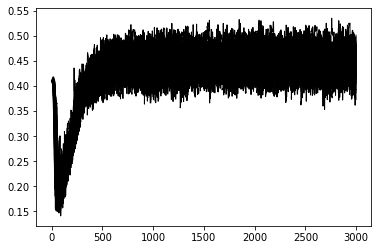

In [23]:
#CHECK HOW LONG A BURN-IN IS NEEDED BEFORE FIT RESULTS STABILIZE
for i in range(0,nwalkers-1):
    plt.plot(sampler.chain[i,:,4],linewidth=1,color='black')

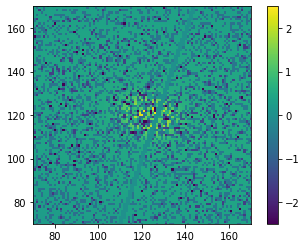

In [24]:
#EXAMINE RESIDUALS NEAR THE CENTER OF THE GALAXY
plt.imshow(model_counts.T*(1-gap_mask.T)-data_counts.T*(1-gap_mask.T),origin="lower")
plt.colorbar()
plt.xlim(70,170)
plt.ylim(70,170)
plt.clim(-2.5,2.5)